In [1]:
! pip install astroNN
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow import keras
import cv2
import time
from keras.preprocessing.image import ImageDataGenerator
import torch
import torchvision.models as models

ModuleNotFoundError: No module named 'torch'

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D,BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras import utils

from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import MobileNetV2
from keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

In [3]:
images, labels = galaxy10.load_data()

C:\Users\First One\.astroNN\datasets\Galaxy10_DECals.h5 was found!


In [4]:
def resize_image(images):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (64, 64))
        resized_images.append(resized_image)
    
    resized_images = np.array(resized_images)
    return resized_images

In [5]:
def normalize_data(x):
    x = np.array(x)
    x_normalized = (x.astype(np.float32) - 127.5)/127.5
    return x_normalized

In [6]:
resized_images = resize_image(images)
normalized_images = normalize_data(resized_images)

In [15]:
def best_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    return model

In [16]:
model_basic = best_model()

In [77]:
model_basic.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 8, 128)        

In [17]:
model_basic.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
x_train, x_test, y_train, y_test = train_test_split(normalized_images, labels, test_size=0.2,random_state=42,stratify=labels)

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42,stratify=y_train)

In [20]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [22]:
start_time = time.time()
history = model_basic.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20,
                          validation_data=(x_val, y_val), verbose=1,
                          callbacks=[early_stopping])

end_time = time.time()

Epoch 1/20
355/355 [==============================] - 75s 198ms/step - loss: 1.9950 - accuracy: 0.2481 - val_loss: 1.9305 - val_accuracy: 0.2555
Epoch 2/20
355/355 [==============================] - 70s 197ms/step - loss: 1.5299 - accuracy: 0.4183 - val_loss: 1.3625 - val_accuracy: 0.4796
Epoch 3/20
355/355 [==============================] - 70s 197ms/step - loss: 1.3433 - accuracy: 0.5013 - val_loss: 1.1709 - val_accuracy: 0.5624
Epoch 4/20
355/355 [==============================] - 69s 195ms/step - loss: 1.2179 - accuracy: 0.5581 - val_loss: 1.1379 - val_accuracy: 0.5881
Epoch 5/20
355/355 [==============================] - 70s 197ms/step - loss: 1.1295 - accuracy: 0.6003 - val_loss: 1.0742 - val_accuracy: 0.6180
Epoch 6/20
355/355 [==============================] - 70s 197ms/step - loss: 1.0628 - accuracy: 0.6337 - val_loss: 1.0205 - val_accuracy: 0.6367
Epoch 7/20
355/355 [==============================] - 69s 195ms/step - loss: 1.0029 - accuracy: 0.6493 - val_loss: 0.9777 - val_ac

In [23]:
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))

Training time: 1401.54 seconds


In [24]:
test_predictions_basic = model_basic.predict(x_test)
test_predictions_basic = np.argmax(test_predictions_basic, axis=1) 

111/111 [==============================] - 6s 46ms/step


In [25]:
print(classification_report(y_test, test_predictions_basic))

              precision    recall  f1-score   support

           0       0.78      0.08      0.15       216
           1       0.70      0.81      0.75       371
           2       0.88      0.86      0.87       529
           3       0.83      0.84      0.84       405
           4       0.61      0.49      0.55        67
           5       0.70      0.73      0.71       409
           6       0.60      0.66      0.63       366
           7       0.61      0.61      0.61       526
           8       0.77      0.89      0.83       284
           9       0.76      0.87      0.81       375

    accuracy                           0.73      3548
   macro avg       0.73      0.69      0.68      3548
weighted avg       0.73      0.73      0.71      3548



In [80]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, test_predictions_basic)

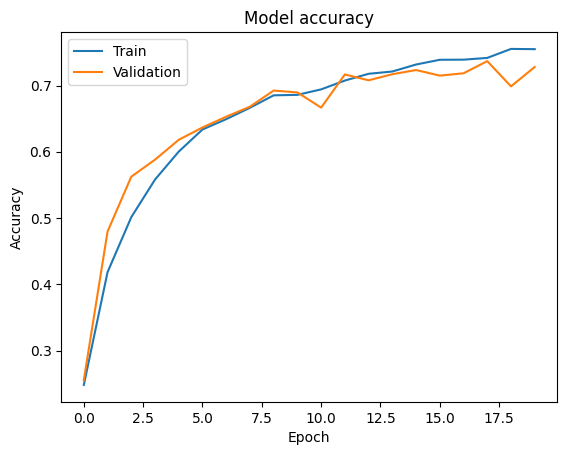

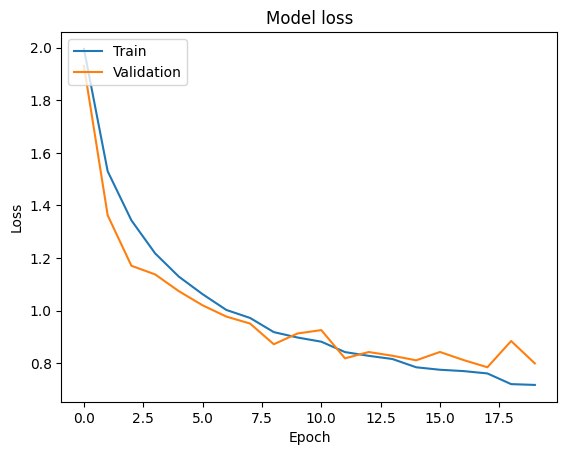

In [86]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
vgg16_base = VGG16(weights=None, include_top=False, input_shape=(64, 64, 3))

x = Flatten()(vgg16_base.output)
x = Dense(512, activation='relu')(x) 
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_vgg16 = Model(inputs=vgg16_base.input, outputs=output)

In [33]:
# Compile the model
model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
start_time_vgg16 = time.time()
history_vgg16 = model_vgg16.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stopping])
end_time_vgg16 = time.time()
training_time_vgg16 = end_time_vgg16 - start_time_vgg16
print("Training time: {:.2f} seconds".format(training_time_vgg16))

Epoch 1/20
355/355 [==============================] - 468s 1s/step - loss: 2.3619 - accuracy: 0.1463 - val_loss: 2.2208 - val_accuracy: 0.1490
Epoch 2/20
355/355 [==============================] - 460s 1s/step - loss: 2.2231 - accuracy: 0.1445 - val_loss: 2.2199 - val_accuracy: 0.1483
Epoch 3/20
355/355 [==============================] - 456s 1s/step - loss: 2.2216 - accuracy: 0.1436 - val_loss: 2.2234 - val_accuracy: 0.1483
Epoch 4/20
355/355 [==============================] - 462s 1s/step - loss: 2.2213 - accuracy: 0.1488 - val_loss: 2.2196 - val_accuracy: 0.1490
Epoch 5/20
355/355 [==============================] - 472s 1s/step - loss: 2.2211 - accuracy: 0.1440 - val_loss: 2.2194 - val_accuracy: 0.1483
Epoch 6/20
355/355 [==============================] - 464s 1s/step - loss: 2.2211 - accuracy: 0.1433 - val_loss: 2.2200 - val_accuracy: 0.1483
Epoch 7/20
355/355 [==============================] - 462s 1s/step - loss: 2.2204 - accuracy: 0.1447 - val_loss: 2.2194 - val_accuracy: 0.1483

In [35]:
test_predictions_vgg16 = model_vgg16.predict(x_test)
test_predictions_vgg16 = np.argmax(test_predictions_vgg16, axis=1) 

111/111 [==============================] - 41s 369ms/step


In [36]:
print(classification_report(y_test, test_predictions_vgg16))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.00      0.00      0.00       371
           2       0.00      0.00      0.00       529
           3       0.00      0.00      0.00       405
           4       0.00      0.00      0.00        67
           5       0.00      0.00      0.00       409
           6       0.00      0.00      0.00       366
           7       0.15      1.00      0.26       526
           8       0.00      0.00      0.00       284
           9       0.00      0.00      0.00       375

    accuracy                           0.15      3548
   macro avg       0.01      0.10      0.03      3548
weighted avg       0.02      0.15      0.04      3548



C:\Users\First One\anaconda3\envs\ayat\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\First One\anaconda3\envs\ayat\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\First One\anaconda3\envs\ayat\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [26]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in vgg_base.layers:
    layer.trainable = False

vgg_base.layers[-2].trainable = True

x = Flatten()(vgg_base.output)
x = Dense(512, activation='relu')(x)  
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_pre_vgg16 = Model(inputs=vgg_base.input, outputs=output)

In [27]:
# Compile the model
model_pre_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
start_time_pvgg16 = time.time()
history_pvgg16 = model_pre_vgg16.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stopping])
end_time_pvgg16 = time.time()
training_time_pvgg16 = end_time_pvgg16 - start_time_pvgg16
print("Training time: {:.2f} seconds".format(training_time_pvgg16))

Epoch 1/20
355/355 [==============================] - 319s 887ms/step - loss: 1.6085 - accuracy: 0.4008 - val_loss: 1.3822 - val_accuracy: 0.4774
Epoch 2/20
355/355 [==============================] - 314s 883ms/step - loss: 1.4049 - accuracy: 0.4819 - val_loss: 1.3686 - val_accuracy: 0.5014
Epoch 3/20
355/355 [==============================] - 285s 801ms/step - loss: 1.3333 - accuracy: 0.5129 - val_loss: 1.3724 - val_accuracy: 0.4898
Epoch 4/20
355/355 [==============================] - 195s 549ms/step - loss: 1.3035 - accuracy: 0.5263 - val_loss: 1.2802 - val_accuracy: 0.5444
Epoch 5/20
355/355 [==============================] - 194s 546ms/step - loss: 1.2600 - accuracy: 0.5429 - val_loss: 1.2100 - val_accuracy: 0.5620
Epoch 6/20
355/355 [==============================] - 196s 552ms/step - loss: 1.2549 - accuracy: 0.5442 - val_loss: 1.4941 - val_accuracy: 0.4852
Epoch 7/20
355/355 [==============================] - 194s 548ms/step - loss: 1.2340 - accuracy: 0.5544 - val_loss: 1.3647 -

In [30]:
test_predictions_pvgg16 = model_pre_vgg16.predict(x_test)
test_predictions_pvgg16 = np.argmax(test_predictions_pvgg16, axis=1) 

111/111 [==============================] - 42s 383ms/step


In [31]:
print(classification_report(y_test, test_predictions_pvgg16))

              precision    recall  f1-score   support

           0       0.56      0.06      0.12       216
           1       0.49      0.46      0.47       371
           2       0.70      0.77      0.73       529
           3       0.53      0.65      0.59       405
           4       0.29      0.34      0.32        67
           5       0.49      0.50      0.50       409
           6       0.55      0.34      0.42       366
           7       0.43      0.50      0.46       526
           8       0.74      0.86      0.79       284
           9       0.66      0.78      0.72       375

    accuracy                           0.56      3548
   macro avg       0.54      0.53      0.51      3548
weighted avg       0.56      0.56      0.55      3548



In [37]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in resnet_base.layers:
    layer.trainable = False
resnet_base.layers[-2].trainable = True

x = Flatten()(resnet_base.output)
x = Dense(512, activation='relu')(x)  
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_pre_Res = Model(inputs=resnet_base .input, outputs=output)

In [38]:
model_pre_Res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
start_time_pRes = time.time()
history_pRes = model_pre_Res.fit(x_train, y_train, batch_size=32, epochs=20,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stopping])
end_time_pRes = time.time()
training_time_pRes = start_time_pRes - end_time_pRes
print("Training time: {:.2f} seconds".format(training_time_pRes))

Epoch 1/20
355/355 [==============================] - 95s 268ms/step - loss: 1.5586 - accuracy: 0.4202 - val_loss: 1.5483 - val_accuracy: 0.4158
Epoch 2/20
355/355 [==============================] - 98s 276ms/step - loss: 1.5264 - accuracy: 0.4342 - val_loss: 1.5183 - val_accuracy: 0.4302
Epoch 3/20
355/355 [==============================] - 95s 269ms/step - loss: 1.4971 - accuracy: 0.4419 - val_loss: 1.4756 - val_accuracy: 0.4609
Epoch 4/20
355/355 [==============================] - 96s 270ms/step - loss: 1.4673 - accuracy: 0.4555 - val_loss: 1.4564 - val_accuracy: 0.4704
Epoch 5/20
355/355 [==============================] - 96s 270ms/step - loss: 1.4424 - accuracy: 0.4673 - val_loss: 1.4953 - val_accuracy: 0.4450
Epoch 6/20
355/355 [==============================] - 96s 271ms/step - loss: 1.4149 - accuracy: 0.4784 - val_loss: 1.4574 - val_accuracy: 0.4686
Epoch 7/20
355/355 [==============================] - 96s 270ms/step - loss: 1.4013 - accuracy: 0.4848 - val_loss: 1.5033 - val_ac

In [46]:
test_predictions_pRes = model_pre_Res.predict(x_test)
test_predictions_pRes = np.argmax(test_predictions_pRes, axis=1) 

111/111 [==============================] - 19s 174ms/step


In [47]:
print(classification_report(y_test, test_predictions_pRes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.39      0.37      0.38       371
           2       0.44      0.80      0.57       529
           3       0.48      0.44      0.46       405
           4       0.33      0.10      0.16        67
           5       0.40      0.13      0.20       409
           6       0.42      0.50      0.45       366
           7       0.35      0.37      0.36       526
           8       0.66      0.82      0.73       284
           9       0.60      0.62      0.61       375

    accuracy                           0.46      3548
   macro avg       0.41      0.41      0.39      3548
weighted avg       0.42      0.46      0.42      3548



In [72]:
Resnet_base = ResNet50(weights= None , include_top=False, input_shape=(64, 64, 3))

x = Flatten()(Resnet_base.output)
x = Dense(512, activation='relu')(x)  
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_Res = Model(inputs=Resnet_base .input, outputs=output)

In [73]:
model_Res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [74]:
start_time_Res = time.time()
history_Res = model_Res.fit(x_train, y_train, batch_size=32, epochs=20,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stopping])
end_time_Res = time.time()
training_time_Res = start_time_Res - end_time_Res
print("Training time: {:.2f} seconds".format(training_time_Res))

Epoch 1/20
355/355 [==============================] - 273s 709ms/step - loss: 2.2575 - accuracy: 0.3240 - val_loss: 2.0046 - val_accuracy: 0.2512
Epoch 2/20
355/355 [==============================] - 253s 713ms/step - loss: 1.4421 - accuracy: 0.4768 - val_loss: 1.3918 - val_accuracy: 0.5095
Epoch 3/20
355/355 [==============================] - 253s 713ms/step - loss: 1.3368 - accuracy: 0.5200 - val_loss: 3.0233 - val_accuracy: 0.2259
Epoch 4/20
355/355 [==============================] - 252s 709ms/step - loss: 1.3421 - accuracy: 0.5210 - val_loss: 1.7712 - val_accuracy: 0.4165
Epoch 5/20
355/355 [==============================] - 251s 708ms/step - loss: 1.2425 - accuracy: 0.5591 - val_loss: 1.5196 - val_accuracy: 0.4958
Training time: -1282.25 seconds


In [75]:
test_predictions_Res =  model_Res.predict(x_test)
test_predictions_Res = np.argmax(test_predictions_Res, axis=1)

111/111 [==============================] - 22s 190ms/step


In [76]:
print(classification_report(y_test, test_predictions_Res))

              precision    recall  f1-score   support

           0       0.47      0.03      0.06       216
           1       0.40      0.39      0.40       371
           2       0.52      0.90      0.66       529
           3       0.55      0.67      0.60       405
           4       0.11      0.03      0.05        67
           5       0.49      0.11      0.17       409
           6       0.45      0.37      0.41       366
           7       0.38      0.40      0.39       526
           8       0.61      0.87      0.72       284
           9       0.61      0.70      0.65       375

    accuracy                           0.50      3548
   macro avg       0.46      0.44      0.41      3548
weighted avg       0.49      0.50      0.46      3548



In [54]:
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in mobilenet_base.layers:
    layer.trainable = False
mobilenet_base.layers[-2].trainable = True

x = Flatten()(mobilenet_base.output)
x = Dense(512, activation='relu')(x)  
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)


model_pre_mob = Model(inputs=mobilenet_base.input, outputs=output)

In [55]:
model_pre_mob.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
start_time_pmob = time.time()
history_pmob = model_pre_mob.fit(x_train, y_train, batch_size=32, epochs=20,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stopping])
end_time_pmob = time.time()
training_time_pmob = start_time_pmob - end_time_pmob
print("Training time: {:.2f} seconds".format(training_time_pmob))

Epoch 1/20
355/355 [==============================] - 29s 74ms/step - loss: 1.6853 - accuracy: 0.4062 - val_loss: 1.5513 - val_accuracy: 0.4316
Epoch 2/20
355/355 [==============================] - 27s 77ms/step - loss: 1.3778 - accuracy: 0.4907 - val_loss: 1.4887 - val_accuracy: 0.4669
Epoch 3/20
355/355 [==============================] - 27s 77ms/step - loss: 1.2016 - accuracy: 0.5604 - val_loss: 1.5246 - val_accuracy: 0.4528
Epoch 4/20
355/355 [==============================] - 27s 77ms/step - loss: 1.0399 - accuracy: 0.6159 - val_loss: 1.6204 - val_accuracy: 0.4612
Epoch 5/20
355/355 [==============================] - 27s 76ms/step - loss: 0.8528 - accuracy: 0.6884 - val_loss: 1.7331 - val_accuracy: 0.4204
Training time: -138.21 seconds


In [57]:
test_predictions_pmob = model_pre_mob.predict(x_test)
test_predictions_pmob = np.argmax(test_predictions_pmob, axis=1)

111/111 [==============================] - 5s 43ms/step


In [58]:
print(classification_report(y_test, test_predictions_pmob))

              precision    recall  f1-score   support

           0       0.23      0.04      0.07       216
           1       0.40      0.33      0.37       371
           2       0.46      0.73      0.57       529
           3       0.40      0.32      0.36       405
           4       0.35      0.12      0.18        67
           5       0.54      0.30      0.39       409
           6       0.37      0.51      0.43       366
           7       0.40      0.40      0.40       526
           8       0.76      0.70      0.73       284
           9       0.59      0.77      0.67       375

    accuracy                           0.47      3548
   macro avg       0.45      0.42      0.41      3548
weighted avg       0.46      0.47      0.45      3548



In [67]:
Mobilenet_base = MobileNet(weights= None, include_top=False, input_shape=(64, 64, 3))

x = Flatten()(Mobilenet_base.output)
x = Dense(512, activation='relu')(x)  
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_mob = Model(inputs=Mobilenet_base.input, outputs=output)

In [68]:
model_mob.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [69]:
start_time_mob = time.time()
history_mob = model_mob.fit(x_train, y_train, batch_size=32, epochs=20,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stopping])
end_time_mob = time.time()
training_time_mob = start_time_mob - end_time_mob
print("Training time: {:.2f} seconds".format(training_time_mob))

Epoch 1/20
355/355 [==============================] - 76s 190ms/step - loss: 1.9825 - accuracy: 0.2780 - val_loss: 2.4386 - val_accuracy: 0.1490
Epoch 2/20
355/355 [==============================] - 63s 178ms/step - loss: 1.4900 - accuracy: 0.4589 - val_loss: 1.5915 - val_accuracy: 0.4239
Epoch 3/20
355/355 [==============================] - 63s 178ms/step - loss: 1.3481 - accuracy: 0.5186 - val_loss: 1.8112 - val_accuracy: 0.3848
Epoch 4/20
355/355 [==============================] - 66s 185ms/step - loss: 1.2332 - accuracy: 0.5634 - val_loss: 1.5453 - val_accuracy: 0.5088
Epoch 5/20
355/355 [==============================] - 66s 185ms/step - loss: 1.1586 - accuracy: 0.5899 - val_loss: 1.7831 - val_accuracy: 0.4479
Epoch 6/20
355/355 [==============================] - 67s 188ms/step - loss: 1.1014 - accuracy: 0.6159 - val_loss: 1.4238 - val_accuracy: 0.5078
Epoch 7/20
355/355 [==============================] - 66s 186ms/step - loss: 1.0499 - accuracy: 0.6418 - val_loss: 1.7502 - val_ac

In [70]:
test_predictions_mob = model_mob.predict(x_test)
test_predictions_mob = np.argmax(test_predictions_mob, axis=1)

111/111 [==============================] - 5s 41ms/step


In [71]:
print(classification_report(y_test, test_predictions_mob))

              precision    recall  f1-score   support

           0       0.40      0.12      0.19       216
           1       0.68      0.50      0.58       371
           2       0.88      0.67      0.76       529
           3       0.59      0.84      0.70       405
           4       0.20      0.58      0.29        67
           5       0.73      0.56      0.63       409
           6       0.63      0.30      0.41       366
           7       0.40      0.66      0.50       526
           8       0.77      0.81      0.79       284
           9       0.65      0.64      0.64       375

    accuracy                           0.59      3548
   macro avg       0.59      0.57      0.55      3548
weighted avg       0.64      0.59      0.59      3548



In [87]:
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in mobilenetv2_base.layers:
    layer.trainable = False
mobilenetv2_base.layers[-2].trainable = True

x = Flatten()(mobilenetv2_base.output)
x = Dense(512, activation='relu')(x)  
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_pre_MobileNetV2 = Model(inputs=mobilenetv2_base.input, outputs=output)

In [88]:
model_pre_MobileNetV2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [89]:
start_time_pmob2 = time.time()
history_pmob2 = model_pre_MobileNetV2.fit(x_train, y_train, batch_size=32, epochs=20,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stopping])
end_time_pmob2 = time.time()
training_time_pmob2 = start_time_pmob2 - end_time_pmob2
print("Training time: {:.2f} seconds".format(training_time_pmob2))

Epoch 1/20
355/355 [==============================] - 152s 396ms/step - loss: 1.8063 - accuracy: 0.3670 - val_loss: 1.8015 - val_accuracy: 0.3235
Epoch 2/20
355/355 [==============================] - 42s 117ms/step - loss: 1.5040 - accuracy: 0.4468 - val_loss: 1.7381 - val_accuracy: 0.3584
Epoch 3/20
355/355 [==============================] - 42s 119ms/step - loss: 1.3358 - accuracy: 0.5090 - val_loss: 1.7326 - val_accuracy: 0.3506
Epoch 4/20
355/355 [==============================] - 42s 119ms/step - loss: 1.1752 - accuracy: 0.5674 - val_loss: 1.7195 - val_accuracy: 0.3767
Epoch 5/20
355/355 [==============================] - 42s 119ms/step - loss: 1.0167 - accuracy: 0.6242 - val_loss: 1.7585 - val_accuracy: 0.3760
Epoch 6/20
355/355 [==============================] - 41s 116ms/step - loss: 0.8509 - accuracy: 0.6933 - val_loss: 1.8105 - val_accuracy: 0.3858
Epoch 7/20
355/355 [==============================] - 42s 118ms/step - loss: 0.6828 - accuracy: 0.7516 - val_loss: 2.0310 - val_a

In [90]:
test_predictions_pmob2 = model_pre_MobileNetV2.predict(x_test)
test_predictions_pmob2 = np.argmax(test_predictions_pmob2, axis=1)

111/111 [==============================] - 12s 80ms/step


In [91]:
print(classification_report(y_test, test_predictions_pmob2))

              precision    recall  f1-score   support

           0       0.16      0.06      0.08       216
           1       0.26      0.32      0.28       371
           2       0.52      0.32      0.39       529
           3       0.31      0.33      0.32       405
           4       0.33      0.07      0.12        67
           5       0.32      0.49      0.38       409
           6       0.26      0.19      0.22       366
           7       0.29      0.42      0.34       526
           8       0.84      0.40      0.55       284
           9       0.55      0.66      0.60       375

    accuracy                           0.36      3548
   macro avg       0.38      0.33      0.33      3548
weighted avg       0.39      0.36      0.36      3548



In [92]:
MobilenetV2_base = MobileNetV2(weights=None, include_top=False, input_shape=(64, 64, 3))

x = Flatten()(MobilenetV2_base.output)
x = Dense(512, activation='relu')(x)  
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_MobileNetV2 = Model(inputs=MobilenetV2_base.input, outputs=output)

In [93]:
model_MobileNetV2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [98]:
start_time_mob2 = time.time()
history_mob2 = model_MobileNetV2.fit(x_train, y_train, batch_size=32, epochs=20,
                        validation_data=(x_val, y_val), verbose=1,
                        callbacks=[early_stopping])
end_time_mob2 = time.time()
training_time_mob2 = start_time_mob2 - end_time_mob2
print("Training time: {:.2f} seconds".format(training_time_mob2))

Epoch 1/20
355/355 [==============================] - 122s 344ms/step - loss: 1.5489 - accuracy: 0.4411 - val_loss: 2.4164 - val_accuracy: 0.1043
Epoch 2/20
355/355 [==============================] - 125s 353ms/step - loss: 1.3486 - accuracy: 0.5213 - val_loss: 2.8071 - val_accuracy: 0.1043
Epoch 3/20
355/355 [==============================] - 124s 349ms/step - loss: 1.2589 - accuracy: 0.5594 - val_loss: 3.0006 - val_accuracy: 0.1483
Epoch 4/20
355/355 [==============================] - 125s 353ms/step - loss: 1.1482 - accuracy: 0.6017 - val_loss: 2.7835 - val_accuracy: 0.1483
Training time: -497.73 seconds


In [99]:
test_predictions_mob2 = model_MobileNetV2.predict(x_test)
test_predictions_mob2 = np.argmax(test_predictions_mob2, axis=1)

111/111 [==============================] - 10s 89ms/step


In [100]:
print(classification_report(y_test, test_predictions_mob2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.10      1.00      0.19       371
           2       0.00      0.00      0.00       529
           3       0.00      0.00      0.00       405
           4       0.00      0.00      0.00        67
           5       0.00      0.00      0.00       409
           6       0.00      0.00      0.00       366
           7       0.00      0.00      0.00       526
           8       0.00      0.00      0.00       284
           9       0.00      0.00      0.00       375

    accuracy                           0.10      3548
   macro avg       0.01      0.10      0.02      3548
weighted avg       0.01      0.10      0.02      3548



C:\Users\First One\anaconda3\envs\ayat\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\First One\anaconda3\envs\ayat\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\First One\anaconda3\envs\ayat\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
